In [1]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq


# Load the features that we saved before

In [2]:
# Load face features
face_data = np.load(r"C:\Users\Sai lokesh\OneDrive\Documents\jupyter\face_features1.npz")
face_categories1 = face_data['categories']
face_feature1= face_data['features']

# Zip categories and features together
face_features1= list(zip(face_categories1, face_feature1))

# Load patch features
patch_data = np.load(r"C:\Users\Sai lokesh\OneDrive\Documents\jupyter\patch_features1.npz")
patch_categories1= patch_data['categories']
patch_feature1 = patch_data['features']
patch_features1= list(zip(patch_categories1, patch_feature1))

In [3]:
# Load face features
face_data = np.load(r"C:\Users\Sai lokesh\OneDrive\Documents\jupyter\face_features2.npz")
face_categories2 = face_data['categories']
face_feature2= face_data['features']
# Zip categories and features together
face_features2= list(zip(face_categories2, face_feature2))
# Load patch features
patch_data = np.load(r"C:\Users\Sai lokesh\OneDrive\Documents\jupyter\patch_features2.npz")
patch_categories2= patch_data['categories']
patch_feature2= patch_data['features']
patch_features2= list(zip(patch_categories2, patch_feature2))

In [4]:
# Load face features
face_data = np.load(r"C:\Users\Sai lokesh\OneDrive\Documents\jupyter\face_features3.npz")
face_categories3 = face_data['categories']
face_feature3= face_data['features']
# Zip categories and features together
face_features3= list(zip(face_categories3, face_feature3))
# Load patch features
patch_data = np.load(r"C:\Users\Sai lokesh\OneDrive\Documents\jupyter\patch_features3.npz")
patch_categories3= patch_data['categories']
patch_feature3= patch_data['features']
patch_features3= list(zip(patch_categories3, patch_feature3))

# Concatenate all the features

In [5]:
face_feature=np.concatenate((face_feature1, face_feature2,face_feature3))
patch_feature=np.concatenate((face_feature1, patch_feature2,patch_feature3))
face_categories=np.concatenate((face_categories1, face_categories2,face_categories3))
patch_categories=np.concatenate((patch_categories1, patch_categories2,patch_categories3))

# Check the characterstics of faces and patches

In [6]:
# Size, shape, and dimensions of face_feature
print("Face Feature Array:")
print("Size:", face_feature.size)
print("Shape:", face_feature.shape)
print("Dimensions:", face_feature.ndim)
print("Data Type:", face_feature.dtype)

# Size, shape, and dimensions of face_categories
print("\nFace Categories Array:")
print("Size:", len(face_categories))
print("Unique Categories:", np.unique(face_categories))
print("Dimensions:", face_categories.ndim)
print("Data Type:", face_categories.dtype)

# Size, shape, and dimensions of patch_feature
print("\nPatch Feature Array:")
print("Size:", patch_feature.size)
print("Shape:", patch_feature.shape)
print("Dimensions:", patch_feature.ndim)
print("Data Type:", patch_feature.dtype)


Face Feature Array:
Size: 9439232
Shape: (4609, 1, 2048)
Dimensions: 3
Data Type: float32

Face Categories Array:
Size: 4609
Unique Categories: ['fake' 'real']
Dimensions: 1
Data Type: <U4

Patch Feature Array:
Size: 9439232
Shape: (4609, 1, 2048)
Dimensions: 3
Data Type: float32


# Apply Frequency Fourier transform to features
The below code takes the features of faces and patches and applies frequency fourier transform and returns the result.

In [8]:
def perform_fft(features):
    
  
  # Check if it's a single feature or a batch
    if len(features.shape) == 1:
        
        fft_result = fft(features)
    else:
    # Apply FFT to each feature vector in the batch
        
        fft_result = np.apply_along_axis(fft, 1, features)
    return fft_result


# Process face features
face_features_fft = perform_fft(face_feature)
patch_features_fft = perform_fft(patch_feature)

In [10]:
def extract_frequency_features(fft_result):

    # Calculate magnitude spectrum (absolute value)
    magnitude_spectrum = np.abs(fft_result)

    # Calculate additional features (as arrays)
    frequencies = np.arange(len(magnitude_spectrum))  
    mean_frequencies = frequencies * magnitude_spectrum / np.sum(magnitude_spectrum)
    cumulative_energy = np.cumsum(magnitude_spectrum)

    # Return features as arrays
    return {
        "magnitude_spectrum": magnitude_spectrum,
        "mean_frequencies": mean_frequencies,  
        "cumulative_energy": cumulative_energy,
    }


In [11]:
face_frequency_features = {}
for i, feature_fft in enumerate(face_features_fft):
  # Extract features for each face feature
  face_frequency_features[i] = extract_frequency_features(feature_fft)

In [12]:
patch_frequency_features = {}
for i, feature_fft in enumerate(patch_features_fft):
  # Extract features for each patch feature
  patch_frequency_features[i] = extract_frequency_features(feature_fft)

# Concatenate the noise features and frequency features

In [20]:
combined_features = []
for i in range(len(face_feature)):
    
    
    combined_feature = np.concatenate((face_feature[i], patch_feature[i], face_frequency_features[i]["magnitude_spectrum"], patch_frequency_features[i]["magnitude_spectrum"]))
    
    combined_features.append(combined_feature)


combined_features = np.array(combined_features)

print("Combined features shape:", combined_features.shape)

Combined features shape: (4609, 4, 2048)


# Load and Intialize the siamnet model.

In [21]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

input_layer = Input(shape=(8192,), name='input_layer')

#  dense layers for classification
dense1 = Dense(1024, activation='relu', name='dense1')(input_layer)
output_layer = Dense(1, activation='sigmoid', name='output_layer')(dense1)

# Siamese network model
siam_net = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
siam_net.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Training

In the code below, we train the SiamNet model by splitting the data into a 70-30 ratio.

In [26]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train = combined_features.reshape(combined_features.shape[0], -1)  


y_train = np.array([0 if category == 'real' else 1 for category in face_categories])

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)


siam_net.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=11,
    validation_split=0.1
)

Epoch 1/11
91/91 [==============================] - 5s 57ms/step - loss: 0.0395 - accuracy: 0.9866 - val_loss: 0.5071 - val_accuracy: 0.8669
Epoch 2/11
91/91 [==============================] - 5s 52ms/step - loss: 0.0396 - accuracy: 0.9866 - val_loss: 0.5528 - val_accuracy: 0.8390
Epoch 3/11
91/91 [==============================] - 5s 52ms/step - loss: 0.0555 - accuracy: 0.9783 - val_loss: 0.3793 - val_accuracy: 0.8854
Epoch 4/11
91/91 [==============================] - 5s 53ms/step - loss: 0.0770 - accuracy: 0.9721 - val_loss: 0.3520 - val_accuracy: 0.8885
Epoch 5/11
91/91 [==============================] - 5s 51ms/step - loss: 0.0441 - accuracy: 0.9838 - val_loss: 0.4584 - val_accuracy: 0.8607
Epoch 6/11
91/91 [==============================] - 5s 51ms/step - loss: 0.1099 - accuracy: 0.9600 - val_loss: 0.5234 - val_accuracy: 0.8452
Epoch 7/11
91/91 [==============================] - 5s 51ms/step - loss: 0.0733 - accuracy: 0.9724 - val_loss: 0.3952 - val_accuracy: 0.8824
Epoch 8/11
91

# Testing

In [28]:
test_loss, test_accuracy = siam_net.evaluate(X_test,y_test, verbose=1)
print('Test accuracy:', test_accuracy)

44/44 [==============================] - 0s 8ms/step - loss: 0.3537 - accuracy: 0.8980
Test accuracy: 0.8980477452278137


# Confusin Matrix

44/44 [==============================] - 0s 8ms/step


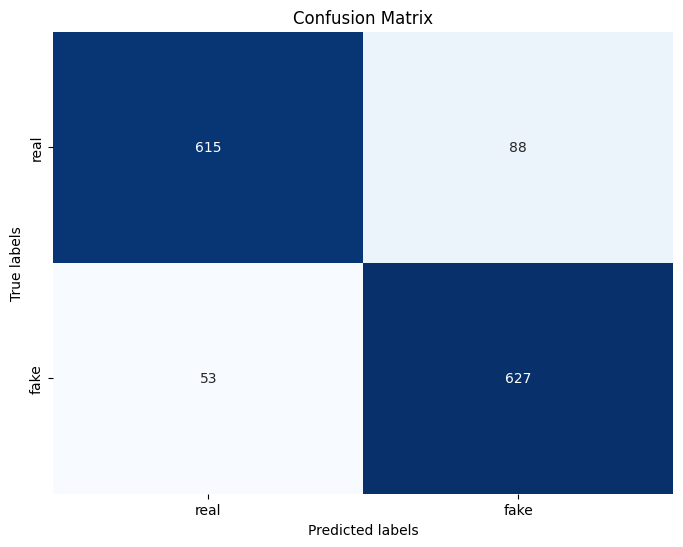

In [29]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
y_pred = siam_net.predict(X_test)
# Convert predicted probabilities to class labels
y_pred_classes = (y_pred > 0.5).astype(int)

# Build confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['real', 'fake'], yticklabels=['real', 'fake'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Save the trained Model

In [24]:
# Save the trained model
siam_net.save("siam_net_model3.h5")


C:\Users\Sai lokesh\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Load the model that was trained before.

In [30]:
from tensorflow.keras.models import load_model
# Load the saved model
loaded_model = load_model("siam_net_model4.h5")


# Training

In [34]:
loaded_model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=6,
    validation_split=0.1
)

Epoch 1/6
91/91 [==============================] - 5s 56ms/step - loss: 0.0243 - accuracy: 0.9907 - val_loss: 0.3388 - val_accuracy: 0.9071
Epoch 2/6
91/91 [==============================] - 5s 52ms/step - loss: 0.0131 - accuracy: 0.9966 - val_loss: 0.2457 - val_accuracy: 0.9195
Epoch 3/6
91/91 [==============================] - 5s 51ms/step - loss: 0.0201 - accuracy: 0.9941 - val_loss: 0.3820 - val_accuracy: 0.9195
Epoch 4/6
91/91 [==============================] - 5s 51ms/step - loss: 0.0151 - accuracy: 0.9955 - val_loss: 0.2684 - val_accuracy: 0.9381
Epoch 5/6
91/91 [==============================] - 5s 51ms/step - loss: 0.0133 - accuracy: 0.9952 - val_loss: 0.2656 - val_accuracy: 0.9319
Epoch 6/6
91/91 [==============================] - 5s 51ms/step - loss: 0.0106 - accuracy: 0.9976 - val_loss: 0.2687 - val_accuracy: 0.9381


# Testing

In [35]:
test_loss, test_accuracy = loaded_model.evaluate(X_test,y_test, verbose=1)
print('Test accuracy:', test_accuracy)

44/44 [==============================] - 0s 8ms/step - loss: 0.1689 - accuracy: 0.9516
Test accuracy: 0.9515545964241028


# Confusion Matrix

44/44 [==============================] - 0s 7ms/step


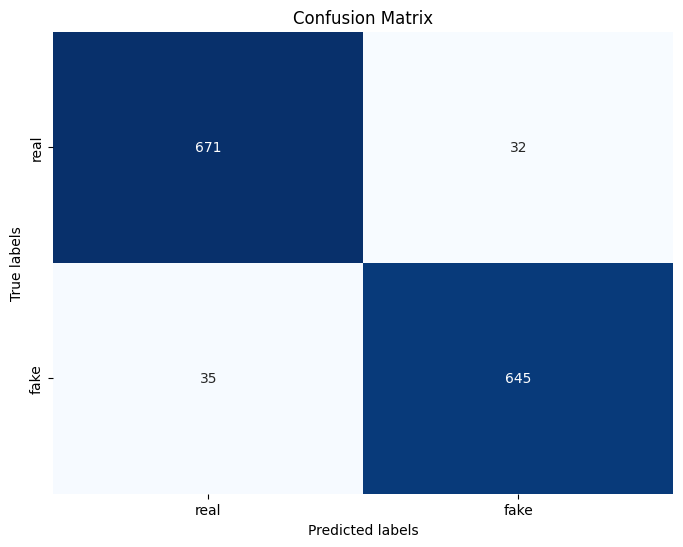

In [36]:
y_pred = loaded_model.predict(X_test)
# Convert predicted probabilities to class labels
y_pred_classes = (y_pred > 0.5).astype(int)

# Build confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['real', 'fake'], yticklabels=['real', 'fake'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Precision

In [37]:
from sklearn.metrics import precision_score, mean_squared_error
y_pred = loaded_model.predict(X_test)
y_pred_class = np.round(y_pred)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_class))
print('Root Mean Squared Error (RMSE):', rmse)

precision = precision_score(y_test, y_pred_class)
print('Precision:', precision)

44/44 [==============================] - 0s 7ms/step
Root Mean Squared Error (RMSE): 0.22010317701518176
Precision: 0.9527326440177253
